# Yelp Reviews Sentiment Analysis - Data Wrangling

#### Prepared by Rabia Tariq: https://github.com/Rabia1995

## Contents

* [Introduction](#Introduction)
* [Imports](#Imports)
* [Scraping](#scrape)
* [Yelp API key](#key)
* [Acquiring Data](#data)
* [Separating Each Review](#separate)
* [Most Common Words](#common_words)
* [Conclusion](#conclusion)

## Introduction<a id='Introduction'></a>

These days one of the most common ways customers use to share their thoughts on a product or a service is through online reviews. There is a huge amount of text data and we can use that data in a productive way by classifying the data in the way we want. Through the text data, the companies can gain insights on the wider public opinion and act accordingly. With having so much data, it is very difficult for a human to read through all of the reviews. So, there needs to be a better way to obtain valuable insights from the vast amounts of text data.

For this project, we are going to be combining Natural Language Processing and web scraping to collect the data from Yelp of different restaurants. After collecting the data, analyzing it, and modeling we will be able to classify the positive and negative reviews and determine the sentiment of different restaurants

## Imports<a id='Imports'></a>

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lxml.html import fromstring
import urllib.request
import requests
import urllib.request
from bs4 import BeautifulSoup
import requests
import json
import random
import pyautogui
import time
import seaborn as sns
sns.set()
from collections import Counter
import re


# Scraping<a id='scrape'></a>

These recources have been used

https://www.bestproxyreviews.com/yelp-scraper/

https://www.scrapingdog.com/blog/how-to-scrape-yelp-reviews

https://www.octoparse.com/blog/web-scraping-using-python#

In [2]:
#To stop getting banned from the site, we have to use proxies

def get_proxies():
    url = 'https://free-proxy-list.net/'
    response = requests.get(url)
    parser = fromstring(response.text)
    proxies = set()
    for i in parser.xpath('//tbody/tr')[:10]:
        if i.xpath('.//td[7][contains(text(),"yes")]'):
        #Grabbing IP and corresponding PORT
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.add(proxy)
    return proxies

In [3]:
proxies = get_proxies()
proxies

{'155.0.181.254:43496',
 '186.167.33.244:42550',
 '31.204.180.44:53281',
 '64.124.38.139:8080',
 '89.36.195.238:35328'}

In [4]:
# We will scrape the url and then use Beautiful Soup

url = 'https://www.yelp.com/biz/chipotle-mexican-grill-new-york-32'

from bs4 import BeautifulSoup, SoupStrainer

proxy = urllib.request.ProxyHandler({'https': proxies})
opener = urllib.request.build_opener()
website = opener.open(url)

html = website.read()
soup = BeautifulSoup(html, "html.parser")

In [6]:
#soup

In [7]:
review=[]
for i in soup.find_all('div',{'class':"margin-b2__373c0__yTb68 border-color--default__373c0__1WKlL"}):
    per_review = i.find_all('span',{'class':"raw__373c0__tQAx6"})
    review.append(per_review)

In [8]:
review

[[<span class="raw__373c0__tQAx6" lang="en">During Cinco de Mayo and National Nurses Week in May, I wasn't surprised to see two of Chipotle's All-Stars, Murphy and Frank, providing a welcoming environment in their financial district location.  <br/><br/>As a Health Care Worker, Chipotle has offered VIP treatment to frontline workers throughout the pandemic and we will not forget their kindness and generosity.<br/><br/>Thank you for another free "Burrito Day" during Nurses Week!</span>],
 [<span class="raw__373c0__tQAx6" lang="en">This may be the worst chipotle location of all time. Never order a mobile order here or it's guaranteed to be completely incorrect. Absolute garbage chicken and small portioning. Always cold and never tastes fresh. Avoid this establishment at all costs. Lazy and inconsiderate workers as well.</span>],
 [<span class="raw__373c0__tQAx6" lang="en">Skimpy portions, order system never works - order to another location as this franchise is under management which spe

In [7]:
#The reviews seem pretty messy, so we are going to clean it up a bit

review_1 = list(filter(None, review))

clean_reviews = []
for i in review_1:
    new_i = str(i).replace('<span class="raw__373c0__tQAx6" lang="en">','')
    new_i = new_i.replace('</span>','')
    new_i = new_i.replace('<br/>','')
    new_i = new_i.replace('<br>','')
    new_i = new_i.replace('[','')
    new_i = new_i.replace(']','')
    new_i = new_i.replace('\xa0','')
    new_i = new_i.replace('\'','')
    
    clean_reviews.append(new_i)

In [8]:
clean_reviews

['During Cinco de Mayo and National Nurses Week in May, I wasnt surprised to see two of Chipotles All-Stars, Murphy and Frank, providing a welcoming environment in their financial district location. As a Health Care Worker, Chipotle has offered VIP treatment to frontline workers throughout the pandemic and we will not forget their kindness and generosity.Thank you for another free "Burrito Day" during Nurses Week!',
 'This may be the worst chipotle location of all time. Never order a mobile order here or its guaranteed to be completely incorrect. Absolute garbage chicken and small portioning. Always cold and never tastes fresh. Avoid this establishment at all costs. Lazy and inconsiderate workers as well.',
 'Skimpy portions, order system never works - order to another location as this franchise is under management which specifically has employees go lighter on portions to save food costs. I get it that food costs have increased but really? Your order will also just be manually taken w

In [9]:
nyc = 'https://data.cityofnewyork.us/resource/59dk-tdhz.json'
session = requests.Session()
session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
raw_data = session.get(nyc)
nyc_data = raw_data.json()

restaurants= []

for i in range(1000):
    name = nyc_data[i]['dba']
    restaurants.append(name)

# test
restaurants[0]

'MORRIS PARK BAKE SHOP'

In [10]:
len(restaurants)

1000

## Yelp API Key<a id='key'></a>

Right now we only have the names of the restaurants. But we need to convert them into valid urls. For that we are going to be using the Yelp API https://www.yelp.com/fusion

In [11]:
api_key='R7RdYrC-3Vn14_7HYeCCQWMnGjDawaGUHRPzb82A71Ke422oB8BsYF0ebZZ0JksksmQmOKjayKCm1ooSAnE5KNYPxn_yEoveQRNbNJmf6E2looaYaVtUDluY3XtfYXYx'
headers = {'Authorization': 'Bearer %s' % api_key}

# this is the url that yelp with search to find a valid business url
search_url='https://api.yelp.com/v3/businesses/search'
 
# in the dictionary, res can take values like food, cafes or businesses
# lets test with the location we just found from the NYC database
params = {'res':restaurants[2],'location':'New York City'}

In [12]:
r = requests.get(search_url, params = params, headers = headers)
 
# proceed only if the status code is 200
print('The status code is {}'.format(r.status_code))

The status code is 200


In [13]:
restaurants_1 = json.loads(r.text)

type(restaurants_1['businesses'])

list

In [16]:
#print(restaurants_1)

# Acquiring Data<a id='data'></a>

After getting the names and the yelp urls of the different restaurants, we are going to create a function that is going to scarpe the useful data (restuarant name, city, zip code, price, reviews, address, etc.) from yelp and store the information in a dataframe. All the parameters can be found here https://www.yelp.com/developers/documentation/v3/business_search


The function is created by taking different elements and modifying from the follwing resources.

https://www.bestproxyreviews.com/yelp-scraper/

https://www.scrapingdog.com/blog/how-to-scrape-yelp-reviews

https://www.octoparse.com/blog/web-scraping-using-python#

In [144]:
#!pip install pyautogui

def Yelp_Scraper(locations):
    
    yelp_data = pd.DataFrame()
    alias_list = []
    name_list = []
    price_list = []
    address_list = []
    city_list = []
    zip_code_list = []
    rating_list = []
    review_list = []
    total_reviews = []
    
    #convert business names to urls  
    for loc in locations:
        sec = random.randint(10,15)
        time.sleep(sec)
        alias = ''
        name = ''
        price = ''
        address = ''
        city = ''
        zip_code = ''
        rating = ''
        all_urls = []
        all_reviews = []
        
        params = {'term':loc, 'location':'New York City'}

        r = requests.get(search_url, params = params, headers = headers)
        
        if r.status_code != 200:
            continue
        
        restaurant_data = json.loads(r.text)

        
        if 'businesses' in restaurant_data:
        
            if isinstance(restaurant_data['businesses'], list):
        
                if 'alias' in restaurant_data['businesses'][0]:
                    alias = restaurant_data['businesses'][0]['alias']
        
                if 'name' in restaurant_data['businesses'][0]:
                    name = restaurant_data['businesses'][0]['name']
            
                if 'rating' in restaurant_data['businesses'][0]:
                    rating = restaurant_data['businesses'][0]['rating']
            
                if 'price' in restaurant_data['businesses'][0]:
                    price = restaurant_data['businesses'][0]['price']
        
                if 'location' in restaurant_data['businesses'][0]:
                    if 'city' in restaurant_data['businesses'][0]['location']:
                        city = restaurant_data['businesses'][0]['location']['city']
                    if 'zip_code' in restaurant_data['businesses'][0]['location']:
                        zip_code = restaurant_data['businesses'][0]['location']['zip_code']
                    if 'display_address' in restaurant_data['businesses'][0]['location']:
                        address = restaurant_data['businesses'][0]['location']['display_address'][0]
                        
                print(name)
        
        alias_list.append(alias)
        name_list.append(name)
        price_list.append(price)
        address_list.append(address)
        city_list.append(city)
        zip_code_list.append(zip_code)
        rating_list.append(rating)
        
        add_url = alias
        parent_url = parent_url = 'https://www.yelp.com/biz/'
        url = parent_url + add_url
        
    #add more urls to get more reviews
    
    
        pages =['?start=10','?start=20','?start=30','?start=40','?start=50','?start=60']
        page1 = url
        page2 = url+pages[0]
        page3 = url+pages[1]
        page4 = url+pages[2]
        page5 = url+pages[3]
        page6 = url+pages[4]
        page7 = url+pages[5]
    
        all_urls.append([page1,page2,page3,page4,page5,page6,page7])
    
    # Scrape all urls
    
        for index in range(len(all_urls[0])):

            url = all_urls[0][index]
            url = url.encode('ascii', 'ignore').decode('ascii')
            response = requests.get(url)
            
            if response.status_code != 200: 
                continue
            r_text = response.text
            soup = BeautifulSoup(r_text,'html.parser')
            
            review = []
            for i in soup.find_all('div',{'class':"margin-b2__373c0__yTb68 border-color--default__373c0__1WKlL"}):
                per_review = i.find_all('span',{'class':"raw__373c0__tQAx6"})
                review.append(per_review)
            new_review = list(filter(None, review))
        
            clean_reviews = []
            for each in new_review:
                new_each = str(each).replace('<span class="raw__373c0__tQAx6" lang="en">','')
                new_each = new_each.replace('<span class="raw__373c0__tQAx6">','')
                new_each = new_each.replace('</span>','')
                new_each = new_each.replace('<br/>','')
                new_each = new_each.replace('<br>','')
                new_each = new_each.replace('[','')
                new_each = new_each.replace(']','')
                new_each = new_each.replace('\xa0','')
                new_each = new_each.replace('\'','')
    
                clean_reviews.append(new_each)
            for review in clean_reviews:
                all_reviews.append(review)
        
        review_list.append(all_reviews)
        total_reviews.append(len(all_reviews))
        #print(total_reviews)
    yelp_data['alias'] = alias_list
    yelp_data['name'] = name_list
    yelp_data['price'] = price_list
    yelp_data['address'] = address_list
    yelp_data['city'] = city_list
    yelp_data['zip_code'] = zip_code_list
    yelp_data['rating'] = rating_list
    yelp_data['reviews'] = review_list
    yelp_data['total_reviews'] = total_reviews
 
    return yelp_data

In [27]:
abc = restaurants[0:3]
test_abc = Yelp_Scraper(abc)

In [35]:
test_abc

,alias,name,price,address,city,zip_code,rating,reviews,total_reviews
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,$$,1007 Morris Park Ave,Bronx,10462,4.5,[Morris Park Bake Shop has become my go to spo...,54
1,wendys-new-york-11,Wendy's,$,85 Nassau Street,New York,10038,3.0,"[They are good.Would I say exceptional, nah. T...",70
2,d-j-reynolds-new-york-5,D.J. Reynolds,$$,351 W 57th St,New York,10019,3.5,[Please note that the new hours are: Tuesday-T...,70


In [35]:
test['reviews'][0][3]

'I had a craving for a special type of cake with both an ice cream layer and a regular cake layer and THIS PLACE MADE IT. We placed our order and the bakery had it ready the next morning. It was beautifully decorated, tasted pretty good, and was only ~$22. Highly recommend this bakery for any custom cake orders!'

I had to remove some of the restaurants, because I was having some trouble with index range

In [147]:
del restaurants[17]
del restaurants[54]
del restaurants[118]
del restaurants[135]
del restaurants[146]
del restaurants[301]
del restaurants[509]
del restaurants[518]
del restaurants[539]
len(restaurants)

990

In [17]:
nyc_restaurants = restaurants[0:160]
yelp_dataset = Yelp_Scraper(nyc_restaurants)

In [28]:
#yelp_dataset.iloc[0:101]

In [46]:
yelp_dataset.to_csv('yelp_dataset.csv', index = None, header = True)

As can be seen some of the restaurants were giving me 0 reviews, so I ran my scarpper function a couple times to collect more reviews and combined them in the dataframe

In [ ]:
nyc_restaurants_2 = restaurants[500:509]
yelp_dataset_2 = Yelp_Scraper(nyc_restaurants_2)

In [38]:
yelp_dataset_2

,alias,name,price,address,city,zip_code,rating,reviews,total_reviews
0,the-beekman-a-thompson-hotel-new-york,"The Beekman, A Thompson Hotel",$$$,123 Nassau St,New York,10038,4.0,[],0
1,peking-duck-house-new-york,Peking Duck House,$$$,28 Mott St,New York,10013,3.0,[],0
2,tea-and-sympathy-new-york,Tea & Sympathy,$$,108 Greenwich Ave,New York,10011,3.5,[While the inside of the shop was small (and a...,70
3,mcdonalds-new-york-411,McDonald's,$,213 Madison St,New York,10002,1.5,[This restaurant saved my marriage. My husband...,32
4,orso-new-york,Orso,$$$,322 W 46th St,New York,10036,4.0,[A friend recommended this restaurant to us an...,70
5,h-and-h-bagels-new-york-6,H&H Bagels,$,1551 2nd Ave,New York,10028,4.0,[Ive been wanting to try H&amp;H bagels for su...,70
6,white-castle-jersey-city,White Castle,$,2995 Kennedy Blvd,Jersey City,07306,3.0,[This is the first White Castle Ive ever been ...,70
7,new-york-marriott-marquis-new-york-3,New York Marriott Marquis,$$$,1535 Broadway,New York,10036,3.5,[The biggest downside of this hotel is that it...,70
8,ihop-brooklyn-10,IHOP,$$,253 Livingston St,Brooklyn,11201,2.0,[What can I say about IHOP that could make it ...,70


In [47]:
yelp_dataset_2.to_csv('yelp_dataset_2.csv', index = None, header = True)

In [ ]:
nyc_restaurants_3 = restaurants[509:539]
yelp_dataset_3 = Yelp_Scraper(nyc_restaurants_3)

In [29]:
#yelp_dataset_3

In [48]:
yelp_dataset_3.to_csv('yelp_dataset_3.csv', index = None, header = True)

In [49]:
yelp_dataset_f = yelp_dataset.append(yelp_dataset_2, ignore_index = True)

In [51]:
yelp_dataset_final = yelp_dataset_f.append(yelp_dataset_3, ignore_index = True)

In [52]:
yelp_dataset_final

,alias,name,price,address,city,zip_code,rating,reviews,total_reviews
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,$$,1007 Morris Park Ave,Bronx,10462,4.5,[Morris Park Bake Shop has become my go to spo...,54
1,wendys-new-york-11,Wendy's,$,85 Nassau Street,New York,10038,3.0,"[They are good.Would I say exceptional, nah. T...",70
2,d-j-reynolds-new-york-5,D.J. Reynolds,$$,351 W 57th St,New York,10019,3.5,[Please note that the new hours are: Tuesday-T...,70
3,riviera-caterers-brooklyn,Riviera Caterers,,2780 Stillwell Ave,Brooklyn,11224,4.5,[I had my wedding here a month ago and I would...,50
4,wilkens-fine-foods-brooklyn-2,Wilkens Fine Foods,$$,7114 Ave U,Brooklyn,11234,3.5,[This place is the BEST. The staff are friendl...,52
...,...,...,...,...,...,...,...,...,...
194,amsterdam-billiards-and-bar-new-york-3,Amsterdam Billiards & Bar,$$,110 E 11th St,New York,10003,3.0,[Great place if you really want to play some l...,60
195,buddys-burrito-and-taco-bar-brooklyn,Buddy's Burrito & Taco Bar,$,260 Court St,Brooklyn,11231,4.0,[The best taco bar in BK.Everything on the men...,70
196,la-boite-en-bois-new-york-2,La Boite en Bois,$$$,75 W 68th St,New York,10023,3.5,"[FOODWe ordered: the duck confit salad, crab c...",70
197,ejs-luncheonette-new-york,EJ's Luncheonette,$$,1271 3rd Ave,New York,10021,3.0,[If you havent stopped by your missing a great...,70


In [70]:
yelp_dataset_final.to_csv('yelp_dataset_final.csv', index = None, header = True)

In [71]:
yelp_dataset_final = yelp_dataset_final[(yelp_dataset_final['total_reviews'] != 0)]

In [117]:
yelp_dataset_final.reset_index(drop = True, inplace = True)

In [74]:
yelp_dataset_final.to_csv('yelp_dataset_FINAL.csv', index = None, header = True)

In [118]:
yelp_dataset_final['reviews'][100][1]

'Took my kids here because they were really hungry. I knew i was going to regret it however It was worse then I thought. They took 1 hour to bring the food out. The place was not even moderately packed. They brought the food out cold. Service is non existent here. The servers are literally giving attitude to because you told them your mozzarella stick order suppose to have 6 sticks not 4. Omg i wish their is a way to get a refund here. The most lazy human beings ok earth work here. Smh. Worse of the worse.'

In [119]:
final_yelp_dataset = yelp_dataset_final

In [120]:
final_yelp_dataset.to_csv('FINAL_yelp_dataset.csv', index = None, header = True)

# Separating each Review<a id='separate'></a>

Now we have a dataset with a list of reviews for eaxh restaurant. We need to separate these reviews for each restaurant so that it can be analyzed separately

In [11]:
yelp_data = pd.read_csv('YELP_DATA_FINAL.csv')

In [12]:
yelp_dataset_unpack = pd.DataFrame()

In [13]:
full_alias = []
full_name = []
full_price = []
full_address = []
full_city = []
full_zip = []
full_rating = []
full_review = []


for index, location in enumerate(yelp_data['alias']):
    
    alias = location
    name = yelp_data[yelp_data['alias'] == location]['name'].values
    rating = yelp_data[yelp_data['alias'] == location]['rating'].values
    price = yelp_data[yelp_data['alias'] == location]['price'].values
    city = yelp_data[yelp_data['alias'] == location]['city'].values
    zip_code = yelp_data[yelp_data['alias'] == location]['zip_code'].values
    address = yelp_data[yelp_data['alias'] == location]['address'].values
    reviews = yelp_data[yelp_data['alias'] == location]['reviews'][index]
    reviews = list(reviews.split("\', "))
    
    for review in reviews:
        
        full_alias.append(alias)
        full_name.append(name[0])
        full_price.append(price[0])
        full_address.append(address[0])
        full_city.append(city[0])
        full_zip.append(zip_code[0])
        full_rating.append(rating[0])
        full_review.append(review)
        
yelp_dataset_unpack['Alias'] = full_alias
yelp_dataset_unpack['Name'] = full_name
yelp_dataset_unpack['Price'] = full_price
yelp_dataset_unpack['Address'] = full_address
yelp_dataset_unpack['City'] = full_city
yelp_dataset_unpack['Zip_code'] = full_zip
yelp_dataset_unpack['Rating'] = full_rating
yelp_dataset_unpack['Review'] = full_review

In [18]:
yelp_dataset_unpack.head()

,Alias,Name,Price,Address,City,Zip_code,Rating,Review
0,morris-park-bake-shop-bronx,Morris Park Bake Shop,$$,1007 Morris Park Ave,Bronx,10462,4.5,['Morris Park Bake Shop has become my go to sp...
1,morris-park-bake-shop-bronx,Morris Park Bake Shop,$$,1007 Morris Park Ave,Bronx,10462,4.5,'I thought the cookies and biscotti were prett...
2,morris-park-bake-shop-bronx,Morris Park Bake Shop,$$,1007 Morris Park Ave,Bronx,10462,4.5,'Guys.... so Im a big time biscotti connoisseu...
3,morris-park-bake-shop-bronx,Morris Park Bake Shop,$$,1007 Morris Park Ave,Bronx,10462,4.5,'I had a craving for a special type of cake wi...
4,morris-park-bake-shop-bronx,Morris Park Bake Shop,$$,1007 Morris Park Ave,Bronx,10462,4.5,'The chocolate cups are amazing! Have been eat...


There are still some punctuations that we need to get rid of.

In [15]:
for index, reviews in enumerate(yelp_dataset_unpack['Review']):
    new_each = str(reviews).replace('[','')
    yelp_dataset_unpack['Review'][index] = new_each

C:\Users\Taimoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
for index, reviews in enumerate(yelp_dataset_unpack['Review']):
    new_each = str(reviews).replace(']','')
    yelp_dataset_unpack['Review'][index] = new_each

C:\Users\Taimoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
yelp_dataset_unpack.to_csv(r'yelp_data.csv',index=False)

Now we can analyze our data

## Most Common Words<a id='common_words'></a>

We can see which words are the most common in the yelp reviews and then we can visualize it. Usually the most common words will be the stop words.

In [17]:
r = yelp_dataset_unpack['Review'][2]

words = re.findall(r'\w+', r.lower())
Counter(words).most_common(10)

[('the', 10),
 ('biscotti', 6),
 ('to', 6),
 ('and', 4),
 ('in', 4),
 ('i', 4),
 ('its', 4),
 ('but', 4),
 ('so', 3),
 ('my', 3)]

In [18]:
all_words = []

for review in yelp_dataset_unpack['Review']:
    words = re.findall(r'\w+', review.lower())
    for word in words:
        all_words.append(word)

In [19]:
common_words = Counter(all_words).most_common(20)

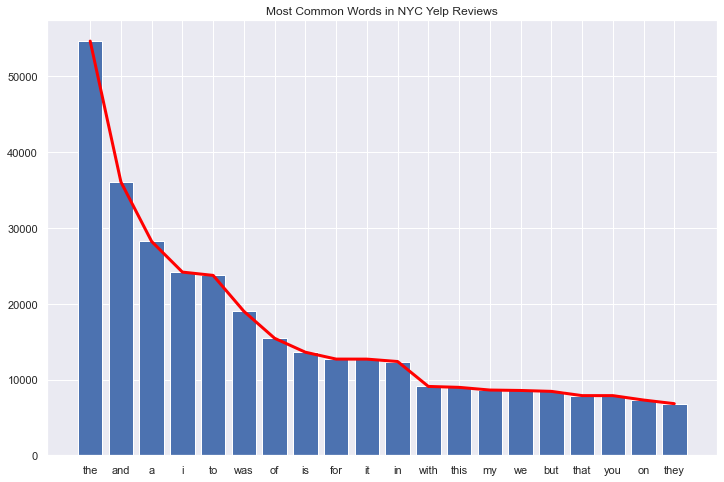

In [22]:
x = pd.DataFrame(common_words, columns = ['word','count']).set_index('word')
plt.figure(figsize=(12,8)) 
plt.bar(x.index, x['count'])
plt.plot(x['count'],color='red',linewidth=3)
plt.title("Most Common Words in NYC Yelp Reviews");

# Conclusion<a id='conclusion'></a>

We have our data. The nect step is to do Exploratory Data Analysis and find trends. We are going to be tokenizing our reviews, counting the words, extracting stop words, using stemming and finding the positive words to get the sense of what the sentiment of the review is.